In [1]:

import datetime
import os
from csbdeep.io import load_training_data
from csbdeep.utils import axes_dict, plot_some,plot_history
import matplotlib.pyplot as plt
# from models import DFCAN
from rdl_denoising.model_DFCAN import DFCAN
from rdl_denoising.loss_functions import mse_ssim, mse_ssim_psnr, mae_ssim
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from wandb.integration.keras import WandbMetricsLogger, WandbEvalCallback
from tensorflow.keras.callbacks import TensorBoard
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse, structural_similarity as ssim, normalized_root_mse as nrmse_sklearn
import numpy as np
import wandb
# from tensorflow.image import psnr, ssim
from skimage.metrics import mean_squared_error
from skimage.metrics import normalized_root_mse as nrmse_sklearn
from csbdeep.data.generate import norm_percentiles
from csbdeep.utils import normalize
import tifffile
import sys
import argparse
import csv


In [1]:
%pip install git+https://github.com/ArghaSarker/RDL_denoising.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/ArghaSarker/RDL_denoising.git to /tmp/pip-req-build-nkmo2k4u
  Running command git clone --filter=blob:none --quiet https://github.com/ArghaSarker/RDL_denoising.git /tmp/pip-req-build-nkmo2k4u
  Resolved https://github.com/ArghaSarker/RDL_denoising.git to commit 5118499d41ccce7267533606aabaf7700cbacb0f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:

root_dir = '../dataset/microtubules'
model_dir = Path(root_dir)/'SRModel'
Path(model_dir).mkdir(exist_ok=True)
train_data_file = f'{root_dir}/train/Train/SR/microtubules_SR_trainig.npz'
val_data_file= f'{root_dir}/val/Train/SR/microtubules_SR_trainig.npz'
log_dir = "logs/fitSR/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [3]:
print('loading validation data')
(X_val,Y_val), _ , axes = load_training_data(val_data_file, verbose=True)

print()
print('loading training data')
(X,Y), _ , axes = load_training_data(train_data_file, verbose=True)
c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

print()
print('data shapes')
print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)

loading validation data
number of training images:	 15
number of validation images:	 0
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 9 / 1

loading training data
number of training images:	 25
number of validation images:	 0
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 9 / 1

data shapes
X shape: (25, 128, 128, 9)
Y shape: (25, 256, 256, 1)
X_val shape: (15, 128, 128, 9)
Y_val shape: (15, 256, 256, 1)


Text(0.5, 0.98, '5 example validation patches (top row: source, bottom row: target)')

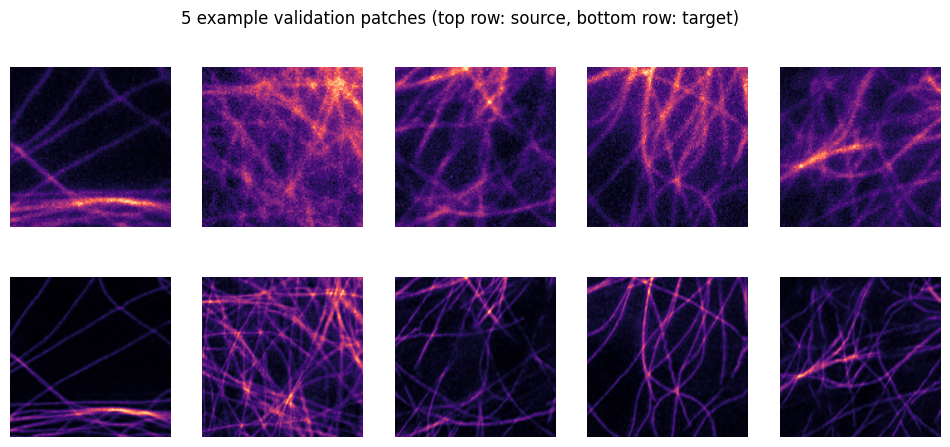

In [4]:
plt.figure(figsize=(12,5))
plot_some(tf.transpose(X_val[:5], perm=[0, 3, 1, 2]),Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)')

In [5]:

init_lr = 1e-4
batch_size = 3
epochs = 5
beta_1=0.9
beta_2=0.999
scale_gt = 2.0

total_data,  height, width, channels= X.shape

In [6]:
Trainingmodel = DFCAN((height, width, channels), scale=scale_gt)
optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
Trainingmodel.compile(loss=mse_ssim, optimizer=optimizer)
#Trainingmodel.summary()

tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
lrate = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1)
hrate = callbacks.History()
srate = callbacks.ModelCheckpoint(
            str(model_dir),
            monitor="loss",
            save_best_only=False,
            save_weights_only=True,
            mode="auto",
        )

In [7]:

if len(os.listdir(model_dir)) > 0:

  with tf.keras.utils.custom_object_scope({'mse_ssim': mse_ssim}):
    if len(os.listdir(model_dir)) > 0:
        print(f'Loading model from {model_dir}')
        Trainingmodel = load_model(model_dir)
history = Trainingmodel.fit(X, Y, batch_size=batch_size,
                              epochs=epochs, validation_data=(X_val, Y_val), shuffle=True,
                              callbacks=[lrate, hrate, srate, tensorboard_callback])


Trainingmodel.save(model_dir)

Epoch 1/5
9/9 [==============================] - 167s 17s/step - loss: 0.5276 - val_loss: 0.4895 - lr: 1.0000e-04
Epoch 2/5
9/9 [==============================] - 134s 15s/step - loss: 0.4661 - val_loss: 0.4443 - lr: 1.0000e-04
Epoch 3/5
9/9 [==============================] - 134s 15s/step - loss: 0.4516 - val_loss: 0.4329 - lr: 1.0000e-04
Epoch 4/5
9/9 [==============================] - 134s 15s/step - loss: 0.4343 - val_loss: 0.4333 - lr: 1.0000e-04
Epoch 5/5
9/9 [==============================] - 134s 15s/step - loss: 0.4297 - val_loss: 0.4147 - lr: 1.0000e-04


INFO:tensorflow:Assets written to: ..\dataset\microtubules\SRModel\assets


INFO:tensorflow:Assets written to: ..\dataset\microtubules\SRModel\assets


## The loss plots

['loss', 'lr', 'val_loss']


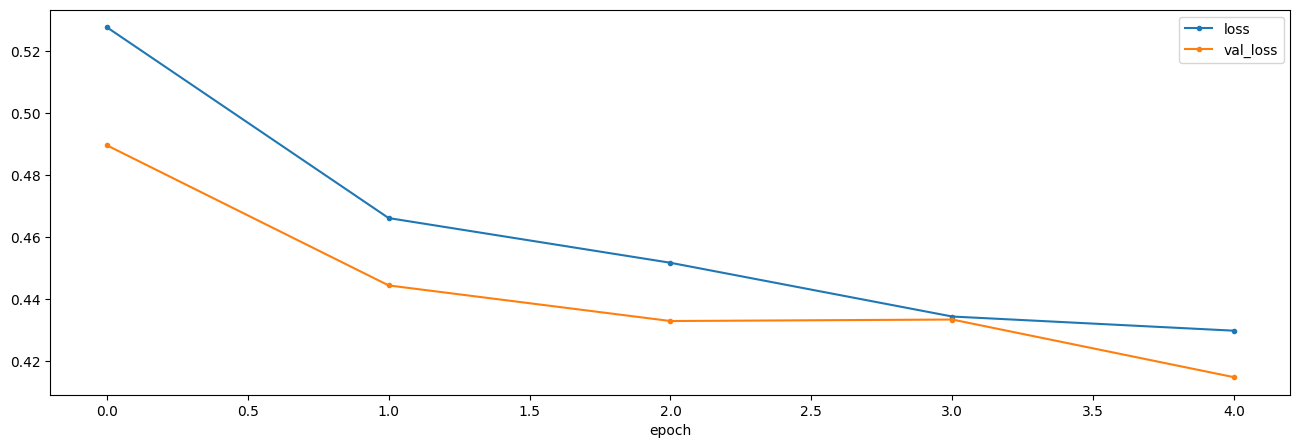

In [8]:

print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'])

# lets see some prediction examples

1/1 [==============================] - 7s 7s/step


Text(0.5, 0.98, '5 example validation patches\ntop row: input (source),  middle row: target (ground truth),  bottom row: predicted from source')

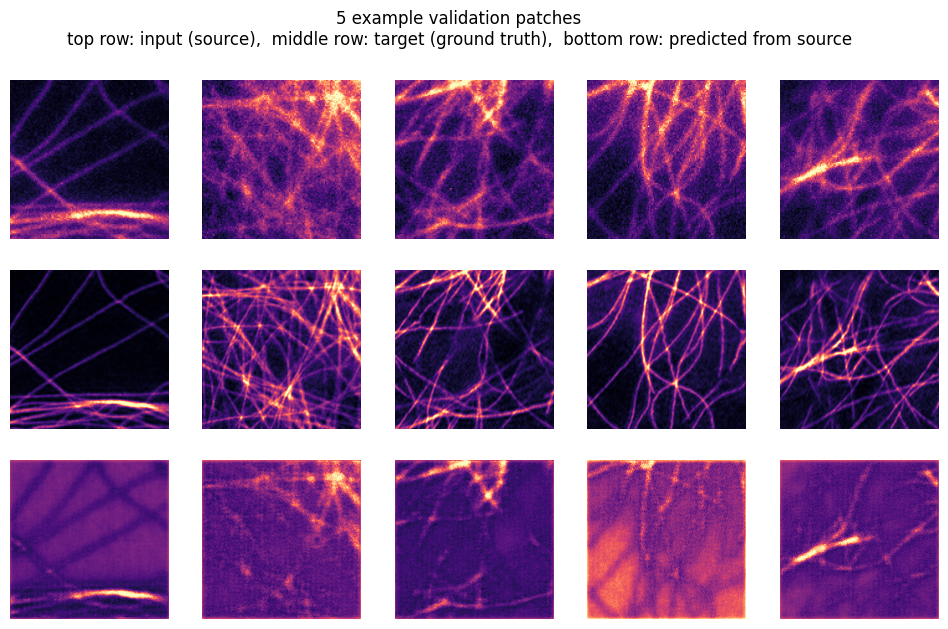

In [9]:

plt.figure(figsize=(12,7))
_P = Trainingmodel.predict(X_val[:5])

plot_some(tf.transpose(X_val[:5], perm=[0, 3, 1, 2]),Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source')